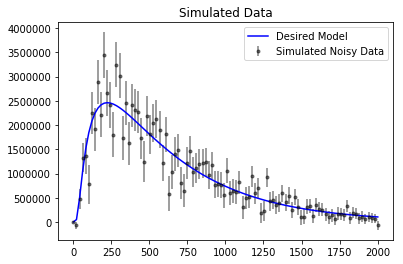

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import celerite as ce
from celerite.modeling import Model
import QPP_Funcs as QPP
from scipy.optimize import minimize

paramstrue = [1e3, 1e3, 3.2e+06, 1e+02, 5e+02]

class CTSModel_prior(Model):
    parameter_names = ("A", "tau1", "tau2")
    
    def get_value(self, t):
        lam = np.exp(np.sqrt(2*(self.tau1/self.tau2)))
        return self.A*lam*np.exp((-self.tau1/t)-(t/self.tau2))
    
    #the gradient terms were manually calculated
    def compute_gradient(self, t):
        lam = np.exp(np.sqrt(2*(self.tau1/self.tau2)))
        dA = (1./self.A) * self.get_value(t)
        dtau1 = ((1/(self.tau2 * np.log(lam))) - (1/t)) * self.get_value(t)
        dtau2 = ((t/(self.tau2**2)) - (self.tau1/((self.tau2**2) * np.log(lam)))) * self.get_value(t)
        return np.array([dA, dtau1, dtau2])
    
    def log_prior(self):
        Aprob = 0.
        tau1prob = 0.
        tau2prob = 0.
        if(self.A>0 and self.A<3.5e7):
            Aprob = 1./(3.5e7)
        #manually entering length of pulse, needs to be fixed
        T=2000
        if(self.tau1>0 and self.tau1<T):
            tau1prob = 1./T
        if(self.tau2>0 and self.tau2<T):
            tau2prob = 1./T
        return np.log(Aprob * tau1prob * tau2prob)

model = CTSModel_prior(A = paramstrue[2], tau1 = paramstrue[3], tau2 = paramstrue[4])    

N = 100
x = np.linspace(1,2001,N)
ytrue = model.get_value(x)
yerrscale = 3e2
yerr = np.sqrt(ytrue) * yerrscale
plt.plot(x, ytrue, 'b-', label = "Desired Model")

def simulate(x, yerr, model):
    K = 0.1*np.exp(-0.5*(x[:, None] - x[None, :])**2/10.5)
    K[np.diag_indices(len(x))] += yerr**2
    y = np.random.multivariate_normal(model.get_value(x), K)
    return y

ysim = simulate(x, yerr, model)

plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

plt.title("Simulated Data")
plt.legend()
plt.show()


Initial log-likelihood: -1437.1156813
Final log-likelihood: -1361.21460013
      fun: 1361.2146001252963
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.07763443e-01,   5.08881200e-10,  -1.18380343e-05,
         1.05495001e-01,  -3.65775949e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 15
      nit: 9
   status: 0
  success: True
        x: array([ -3.57019723e+00,  -6.89727271e-01,   3.19973133e+06,
         1.28248621e+02,   4.83458628e+02])


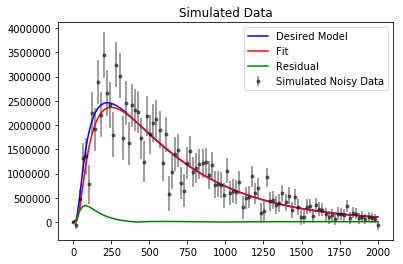

In [52]:
kernel = ce.terms.RealTerm(log_a = np.log(np.var(ysim)), log_c = -np.log(100))
gp = ce.GP(kernel, mean = model, fit_mean = True)
gp.compute(x, yerr)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(ysim)))

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like, method="L-BFGS-B", bounds=bounds, args=(ysim, gp))

gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))
print soln
ytest = model.get_value(x)

plt.plot(x, ytrue, 'b-', label = "Desired Model")
plt.plot(x, ytest, 'r-', label = "Fit")
plt.plot(x, np.abs(ytrue-ytest), 'g-', label = "Residual")
plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

plt.title("Simulated Data")
plt.legend()

plt.show()


In [57]:
paramstart = np.random.multivariate_normal(paramstrue, 1e2*np.identity(len(paramstrue)) * np.sqrt(paramstrue))

#probability function for MCMC
def log_probability(params, y):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not (np.isfinite(lp) or np.isfinite(gp.log_likelihood(y))):
        return -np.inf
    return gp.log_likelihood(y) + lp
gp.compute(x, ysim)

def samplepdf(params):
    return np.random.normal(loc=params, scale=np.sqrt(np.abs(params)))

def MCMCStep(gp, params, y, q, lfunc):
    newparams = q(params)
    r = np.random.rand()
    prob1 = lfunc(gp, y)
    gp.set_parameter_vector(newparams)
    prob2 = lfunc(gp, y)
    if(prob2-prob2==prob2):
        return newparams
    if((prob2/prob1)>r):
        return newparams
    else:
        gp.set_parameter_vector(params)
        return params
    
N = int(1e3)
paramset=np.empty([N,5])
paramset[0] = paramstart
print "Running MCMC..."
for i in range(N-1):
    try:
        paramset[i+1] = MCMCStep(gp, paramset[i], ysim, samplepdf, log_probability)
    except(RuntimeError):
        i-=1

Running MCMC...


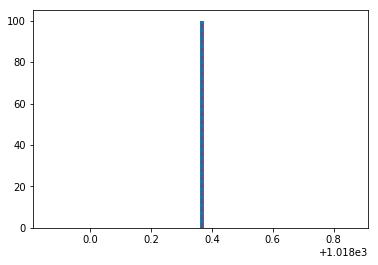

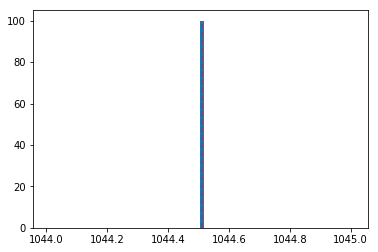

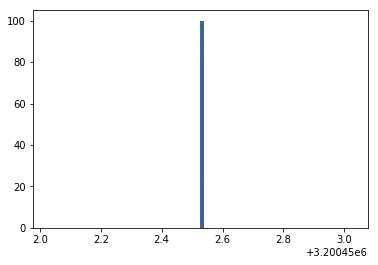

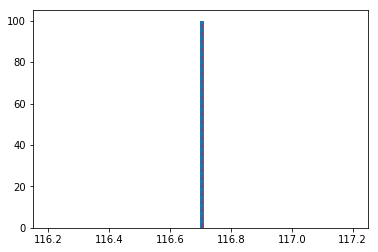

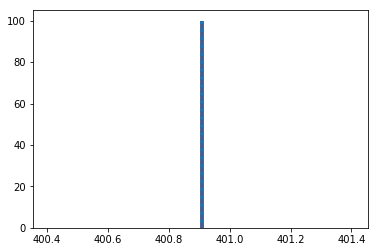

In [58]:
plt.figure()
Ahist, Abins, Apatches = plt.hist(paramset[:,0], normed=1, bins=100)
Ain = np.argmax(Ahist)
AMax = np.average([Abins[Ain], Abins[Ain+1]])
Ax = AMax * np.ones(100)
Ay = np.linspace(0, max(Ahist), 100)
plt.plot(Ax, Ay, 'r--', alpha=0.5)

plt.figure()
chist, cbins, cpatches = plt.hist(paramset[:,1], normed=1, bins=100)
cin = np.argmax(chist)
cMax = np.average([cbins[cin], cbins[cin+1]])
cx = cMax * np.ones(100)
cy = np.linspace(0, max(chist), 100)
plt.plot(cx, cy, 'r--', alpha=0.5)

plt.figure()
ahist, abins, apatches = plt.hist(paramset[:,2], normed=1, bins=100)
ain = np.argmax(ahist)
aMax = np.average([abins[ain], abins[ain+1]])
ax = aMax * np.ones(100)
ay = np.linspace(0, max(ahist), 100)
plt.plot(ax, ay, 'r--', alpha=0.5)

plt.figure()
t1hist, t1bins, t1patches = plt.hist(paramset[:,3], normed=1, bins=100)
t1in = np.argmax(t1hist)
t1Max = np.average([t1bins[t1in], t1bins[t1in+1]])
t1x = t1Max * np.ones(100)
t1y = np.linspace(0, max(t1hist), 100)
plt.plot(t1x, t1y, 'r--', alpha=0.5)

plt.figure()
t2hist, t2bins, t2patches = plt.hist(paramset[:,4], normed=1, bins=100)
t2in = np.argmax(t2hist)
t2Max = np.average([t2bins[t2in], t2bins[t2in+1]])
t2x = t2Max * np.ones(100)
t2y = np.linspace(0, max(t2hist), 100)
plt.plot(t2x, t2y, 'r--', alpha=0.5)

plt.show()

[3200000.0, 100.0, 500.0]
[  3.19973133e+06   1.28248621e+02   4.83458628e+02]
[3200452.5324755828, 116.70479853959745, 400.9088422910462]


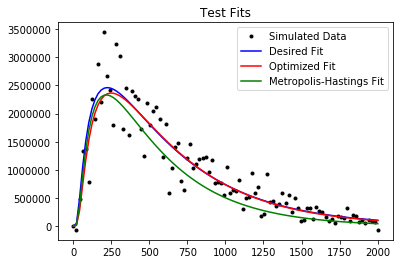

In [66]:
ytest2 = QPP.CTS(x, [aMax, t1Max, t2Max])

print paramstrue[2:]
print soln.x[2:]
print [aMax, t1Max, t2Max]

plt.plot(x, ysim, 'k.', label = "Simulated Data")
plt.plot(x, ytrue, 'b-', label = "Desired Fit")
plt.plot(x, ytest, 'r-', label = "Optimized Fit")
plt.plot(x, ytest2, 'g-', label = "Metropolis-Hastings Fit")
plt.title("Test Fits")
plt.legend()
plt.show()